<a href="https://colab.research.google.com/github/vquinteop/TareasMineriadeDatosSemana1/blob/main/Cuaderno_3_Reg_ejregresion_sinc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo mínimos cuadrados para regresión y su extensión no lineal

Cuaderno modificado por: Valentina Quinter Pamplona

[sklearn.linear model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Regresor lineal por mínimos cuadrados

\begin{equation}
\omega^* = \arg\min_\omega \|y-Xw\|^2_2
\end{equation}


[sklearn.kernel ridge.KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

Regresor rígido kernel



\begin{equation}
\omega^* = \arg\min_\omega \|y-\Phi \omega\|^2_2 + \alpha\|\omega\|^2_2
\end{equation}

\begin{equation}
\omega^* = (\Phi^\top \Phi+\alpha I)^{-1}\Phi^\top y
\end{equation}


\begin{equation}
\omega^* = \Phi^\top(\Phi \Phi^\top+\alpha I)^{-1}y = k(\cdot)^\top(K+\alpha I)^{-1}y
\end{equation}

# Ejercicio 1

- Presente la solución al problema de optimización kernel ridge (Ver [Kernel Ridge Regression](https://web2.qatar.cmu.edu/~gdicaro/10315-Fall19/additional/welling-notes-on-kernel-ridge.pdf))

Despues de ver la expresión que aparece en el artículo, podemos ver que la igualdad en las expresiones, podemos apreciar que:
- $\Phi = B$
- $R = I$ 
- $P=?$ factorizar para que quede $\alpha$

##**Ejemplo** 

- Se pretende generar un modelo de regresión bajo entradas con ruido blanco Gaussiano, con $\mu_\eta=0$, para seguir una función no lineal tipo sinc(x).

- $y = {\rm{sinc}}(x)+\eta$;  
con $\eta\sim p(\eta)=\mathcal{N}(\eta|\mu_\eta,\sigma_\eta^2)=\frac{1}{\sqrt{2\pi\sigma^2_\eta}}\exp\left(\frac{-\|\eta-\mu_\eta\|_2^2}{2\sigma^2_\eta}\right)$

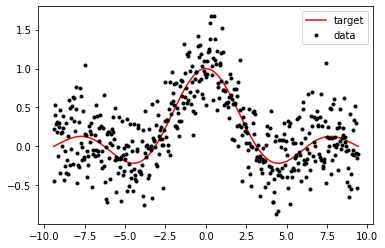

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada 
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.1 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.show()

**Nota:** $${\rm{sinc}}(\theta)=\frac{\sin(\theta)}{\theta}$$

- Se crean los vectores de entrada y salida tipo aprendizaje de máquina.

In [ ]:
ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida

(500, 1)
(500, 1)


- Se entrenará un modelo de aprendizaje con scikitlearn

(350, 1)
(150, 1)


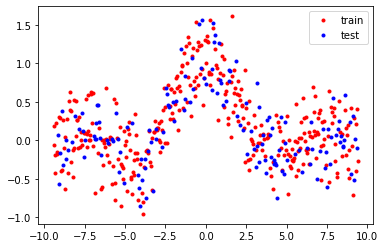

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.show()

- Se utilizará el modelo [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) con función kernel tipo radial basis function (rbf):


$$\kappa(x,x') = \exp\left(\frac{-\gamma\|x-x'\|^2_2}{2}\right)$$

**Nota:** el hiperparámetro $\gamma\in\mathbb{R}^+$ se conoce como precisión y pretende escalar la noción de parecido entre los puntos. La precisión se relaciona comunmente con el parámetro ancho de banda ("varianza") $\sigma\in\mathbb{R}^+$ del modelo rbf, según:

$$\gamma=\frac{1}{\sigma^2}$$

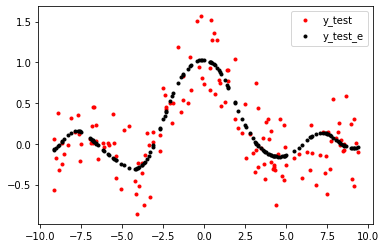

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
gamma = 0.1 #gamma
alpha = 0.001 # valor de regularización
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,y_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)

plt.plot(X_test,y_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.show()

- Es  necesario encontar unos buenos hiperparámetros para seguir la función no lineal

In [ ]:
steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(X_train, y_train)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1902s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1987s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 240 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1914s.) Setting batch_size=8.
[Paralle


Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}


[Parallel(n_jobs=4)]: Done 609 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:    7.2s finished


- Se evaluan los datos de test y train con el mejor modelo encontrado

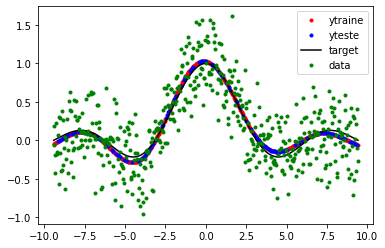

In [ ]:
y_test_e = grid_search.best_estimator_.predict(X_test)
y_train_e = grid_search.best_estimator_.predict(X_train)
plt.plot(X_train,y_train_e,'r.',label='ytraine' )
plt.plot(X_test,y_test_e,'b.',label='yteste')
plt.plot(X,y,'k',label='target' )
plt.plot(Xdata,ydata,'g.',label='data' )
plt.legend()
plt.show()

- Visualicemos la función kernel:

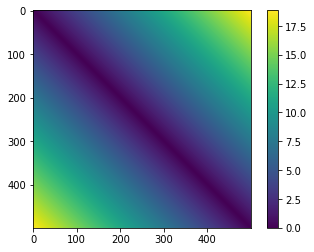

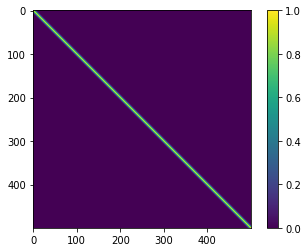

In [ ]:
from sklearn.metrics import pairwise_distances as dist

D = dist(X.reshape(-1,1),X.reshape(-1,1)) #disimilitud
gamma = 100
K = np.exp(-.5*gamma*D**2)
D.shape
plt.imshow(D)
plt.colorbar()
plt.show()


plt.imshow(K)
plt.colorbar()
plt.show()

Recuerde que:

\begin{equation}
\kappa(x,x') = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\|x-x'\|_2^2}{2\sigma^2}\right) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\gamma\|x-x'\|_2^2}{2}\right) 
\end{equation}

#Ejercicio 2 

a. Visualice el kernel rbf para diferentes condiciones de ruido sintonizando los hiperparámetros del modelo utilizando gridsearch.

b. Realice una descomposición en valores propios de la matriz kernel para cada una de las condiciones de ruido del punto anterior, qué puede discutir sobre el espectro de la matríz y su influencia en el modelo predictivo de kernel ridge?. Cuál es la relación entre el espectro visualizado y el hiperparámetro de regularización o penalidad encontrado por gridsearch en cada caso?.




Solución a: se reutiliza el código ya visto y se modifica  la varianza y la media del ruido. Utilizamos 

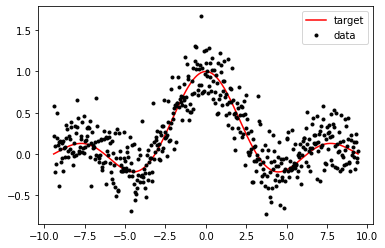

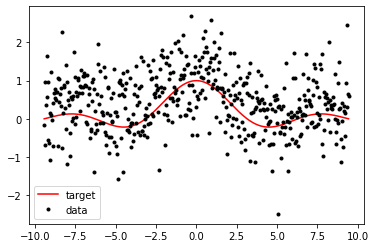

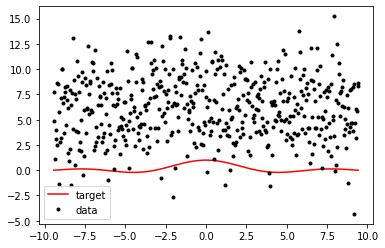

In [22]:
VarN_1 = [0.05, 0.50, 10]
MeanN_1 = [0.0, 0.3, 6]
N_1 = 500 #número de muestras
yn_1 = np.zeros((len(VarN_1),N_1))
X_1 = np.linspace(-3*np.pi,3*np.pi,N_1) #vector de entrada 
y_1 = np.sinc(X_1/np.pi) #función sinc -> objetivo


for i in range(len(VarN_1)):
  var_1 = VarN_1[i] #varianza del ruido
  mue_1 = MeanN_1[i] #media del ruido
  noise_1 = mue_1 + np.sqrt(var_1)*np.random.randn(X_1.shape[0])#ruido blanco
  yn_1[i] = y_1 + noise_1 #señal co ruido
  plt.plot(X_1,y_1,'r',label='target' )
  plt.plot(X_1,yn_1[i],'k.',label='data')
  plt.legend()
  plt.show()

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline

steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

for i in range(len(VarN_1)):
  grid_search.fit(X_1.reshape(-1,1), yn_1[i].reshape(-1,1))
  #mejor modelo entrenado
  best_model = grid_search.best_estimator_

  print("\nMejores parámetros:\n")
  print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1946s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1920s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1642s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 164 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 268 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 388 tasks      | elapsed:    5.1s
[Paralle


Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Batch computation too fast (0.1817s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 268 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 320 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 380 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 508 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 576 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 633 out of 640 | elapsed:    5.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 640 out of 640 | e


Mejores parámetros:

{'reg__alpha': 10, 'reg__gamma': 0.1}
Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1902s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1738s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    4.7s



Mejores parámetros:

{'reg__alpha': 1, 'reg__gamma': 0.001}


[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:    5.7s finished


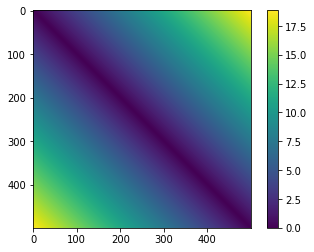

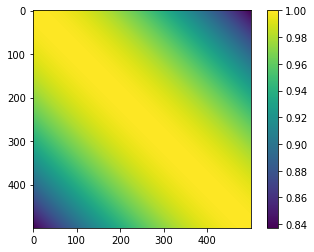

In [24]:
D = dist(X.reshape(-1,1),X.reshape(-1,1)) #disimilitud
gamma = 0.001
K = np.exp(-.5*gamma*D**2)
D.shape
plt.imshow(D)
plt.colorbar()
plt.show()


plt.imshow(K)
plt.colorbar()
plt.show()

In [ ]:
Xdata = X.reshape(-1,1) #N=500, P= 1
y = y.reshape(-1,1)
ydata = yn.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

In [ ]:
steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],              
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(X_train, y_train)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   29.6s
[Parallel(


Mejores parámetros:

{'reg__alpha': 0.001, 'reg__gamma': 0.1}


[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:   58.9s finished


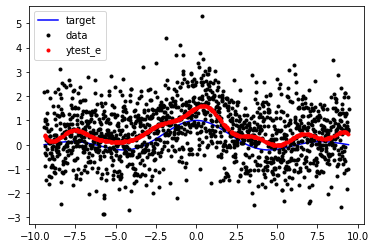

In [ ]:
ytest_e = grid_search.best_estimator_.predict(X_test)

plt.plot(X,y,'b',label='target' )
plt.plot(X,yn,'k.',label='data' )
plt.plot(X_test,ytest_e,'r.',label='ytest_e')
plt.legend()
plt.show()

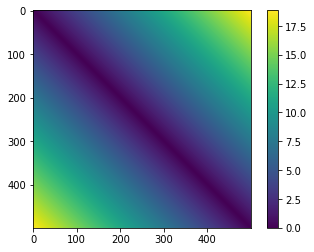

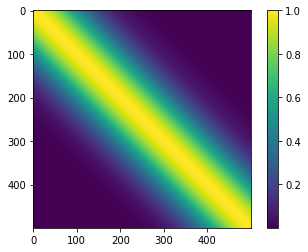

In [21]:
from sklearn.metrics import pairwise_distances as dist

D_1 = dist(X_1.reshape(-1,1),X_1.reshape(-1,1)) #disimilitud
gamma_1 = 0.1
K_1 = np.exp(-.5*gamma_1*D_1**2)
D_1.shape
plt.imshow(D_1)
plt.colorbar()
plt.show()


plt.imshow(K_1)
plt.colorbar()
plt.show()